In [1]:
import pandas as pd
import numpy as np
from backtesting import Backtest, Strategy
import yfinance as yf
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier

# Set random seed
np.random.seed(42)

def compute_rsi(series, window=14):
    delta = series.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

def compute_macd(series, fast=12, slow=26, signal=9):
    ema_fast = series.ewm(span=fast, adjust=False).mean()
    ema_slow = series.ewm(span=slow, adjust=False).mean()
    macd = ema_fast - ema_slow
    signal_line = macd.ewm(span=signal, adjust=False).mean()
    return macd, signal_line

def compute_stochastic_oscillator(high, low, close, k_period=14, d_period=3):
    lowest_low = low.rolling(window=k_period).min()
    highest_high = high.rolling(window=k_period).max()
    stoch_k = 100 * (close - lowest_low) / (highest_high - lowest_low)
    stoch_d = stoch_k.rolling(window=d_period).mean()
    return stoch_k, stoch_d

def add_features_with_macro(ticker="^GSPC", start="2020-01-30", end="2024-01-01", prediction_horizon=5, big_move_threshold=0.005):
    # Download price data
    df = yf.download(ticker, start=start, end=end)

    # Download macro indicators
    vix = yf.download('^VIX', start=start, end=end)
    tnx = yf.download('^TNX', start=start, end=end)

    # Cleaning the multiindexed columns
    df.columns = [col if isinstance(col, str) else col[0] for col in df.columns]

    # Mid-price & returns
    df['Mid'] = (df['High'] + df['Low']) / 2
    df['Return'] = df['Close'].pct_change()
    df['Mid_Return'] = df['Mid'].pct_change()

    # Technical indicators
    df['MA5'] = df['Close'].rolling(window=5).mean()
    df['MA10'] = df['Close'].rolling(window=10).mean()
    df['MA20'] = df['Close'].rolling(window=20).mean()
    df['Volatility'] = df['Return'].rolling(window=10).std()
    df['Momentum'] = df['Close'] - df['Close'].shift(5)
    df['RSI'] = compute_rsi(df['Close'])
    df['MACD'], df['MACD_signal'] = compute_macd(df['Close'])
    df['Stoch_K'], df['Stoch_D'] = compute_stochastic_oscillator(df['High'], df['Low'], df['Close'])

    # Macro indicators (align by date index)
    df['VIX_Close'] = vix['Close']
    df['TNX_Close'] = tnx['Close']

    # Future return target
    df['Future_Return'] = df['Close'].shift(-prediction_horizon) / df['Close'] - 1

    # Multi-class label: big moves only
    df['Target'] = np.where(df['Future_Return'] > big_move_threshold, 2,
                    np.where(df['Future_Return'] < -big_move_threshold, 0, 1))

    # Feature columns (can customize if needed)
    df['X_MA5'] = (df['Close'] - df['MA5']) / df['Close']
    df['X_MA10'] = (df['Close'] - df['MA10']) / df['Close']
    df['X_MA20'] = (df['Close'] - df['MA20']) / df['Close']
    df['X_MA5_10'] = (df['MA5'] - df['MA10']) / df['Close']
    df['X_MA10_20'] = (df['MA10'] - df['MA20']) / df['Close']
    df['X_Volatility'] = df['Volatility']
    df['X_Momentum'] = df['Momentum']
    df['X_Return'] = df['Return']
    df['X_Return_5'] = df['Return'].rolling(5).sum()
    df['X_VOL_CHG'] = df['Volume'].pct_change(5)
    df['X_RSI'] = df['RSI']
    df['X_MACD'] = df['MACD']
    df['X_MACD_signal'] = df['MACD_signal']
    df['X_Stoch_K'] = df['Stoch_K']
    df['X_Stoch_D'] = df['Stoch_D']
    df['X_VIX'] = df['VIX_Close']
    df['X_TNX'] = df['TNX_Close']

    return df  # no dropna(), keep full index

# Helper functions to extract features and labels
def get_X(data):
    feature_columns = [col for col in data.columns if col.startswith('X_')]
    return data[feature_columns].values

def get_y(data):
    """Return target variable y, mapped to [0, 1, 2]"""
    y = data.Target.values
    return data.Target.values
    # return np.where(y == -1, 0, np.where(y == 0, 1, 2))


# Apply features
df = add_features_with_macro()
df = df.dropna(subset=["Open", "High", "Low", "Close", "Volume"])

/opt/anaconda3/lib/python3.12/site-packages/backtesting/_plotting.py:55: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support, such as old IDEs. Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


Loading BokehJS ...

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [2]:
from xgboost import XGBClassifier

class XGBoostStrategy(Strategy):
    n_estimators = 100
    max_depth = 5
    learning_rate = 0.1
    lookback_window = 200  # Dynamic training window size
    price_delta = 0.01  # take-profit and stop-loss % (1%)
    
    def init(self):
        # Feature + label prep
        full_df = add_features_with_macro(ticker="^GSPC").fillna(method='ffill').fillna(method='bfill')
        self.all_data = full_df.loc[self.data.df.index.intersection(full_df.index)]
        
        # Extract features
        self.features = [col for col in self.all_data.columns if col.startswith("X_")]
        
        # Initialize model
        self.model = XGBClassifier(
            n_estimators=self.n_estimators,
            max_depth=self.max_depth,
            learning_rate=self.learning_rate,
            use_label_encoder=False,
            eval_metric='logloss',
            random_state=42
        )
        
        # Prediction tracking
        self.predictions = []
        self.actuals = []
        
    def next(self):
        # Current position in the backtest
        current_idx = len(self.data) - 1
        
        # Safety check - make sure we have enough data
        if current_idx < self.lookback_window:
            return
            
        # Get current data index
        current_candle_time = self.data.index[-1]
        
        try:
            # Find corresponding index in our all_data DataFrame
            idx_in_all_data = self.all_data.index.get_indexer([current_candle_time])[0]
            
            # Check if valid index found
            if idx_in_all_data < 0 or idx_in_all_data < self.lookback_window:
                return
                
            # Safe slicing with loc instead of iloc
            start_idx = self.all_data.index[idx_in_all_data - self.lookback_window + 1]
            end_idx = self.all_data.index[idx_in_all_data]
            train_data = self.all_data.loc[start_idx:end_idx].iloc[:-1]  # All but last point
            test_data = self.all_data.loc[end_idx:end_idx]  # Just the last point
            
            # Check if we have enough data
            if len(train_data) < self.lookback_window // 2:
                return
                
            # Extract features and target
            X_train = train_data[self.features].values
            y_train = train_data["Target"].values
            X_test = test_data[self.features].values
            y_true = test_data["Target"].values[0]
            
            # Train model dynamically on each call
            self.model.fit(X_train, y_train)
            
            # Make prediction
            prediction = self.model.predict(X_test)[0]
                
            # Log predictions and labels
            if prediction in [0, 1, 2]:
                self.predictions.append(prediction)
                self.actuals.append(int(y_true))
                
            # Map prediction to trading signal (-1, 0, 1)
            # Map from [0, 1, 2] to [-1, 0, 1]
            trading_signal_map = {0: -1, 1: 0, 2: 1}
            trading_signal = trading_signal_map[prediction]
                
            # Trade execution with take-profit and stop-loss
            close = self.data.Close[-1]
            tp_long = close * (1 + self.price_delta)
            sl_long = close * (1 - self.price_delta)
            tp_short = close * (1 - self.price_delta)
            sl_short = close * (1 + self.price_delta)
            
            # Trading logic
            if trading_signal == 1:
                if not self.position.is_long:
                    self.position.close()
                    self.buy(tp=tp_long, sl=sl_long)
                    
            elif trading_signal == -1:
                if not self.position.is_short:
                    self.position.close()
                    self.sell(tp=tp_short, sl=sl_short)
                    
            # Risk management with trailing stop
            for trade in self.trades:
                if self.data.index[-1] - trade.entry_time > pd.Timedelta(days=5):
                    if trade.is_long:
                        trade.sl = max(trade.sl, trade.entry_price)
                    else:
                        trade.sl = min(trade.sl, trade.entry_price)
                        
        except (IndexError, KeyError, RuntimeError) as e:
            # Handle exceptions gracefully to avoid breaking the backtest
            pass

In [3]:
from sklearn.metrics import f1_score, accuracy_score, precision_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def evaluate_strategy(y_true, y_pred):

    print("Evaluation Metrics")
    print("Accuracy:", round(accuracy_score(y_true, y_pred), 4))
    print("Precision (macro):", round(precision_score(y_true, y_pred, average='macro'), 4))
    print("F1 Score (macro):", round(f1_score(y_true, y_pred, average='macro'), 4))

    cm = confusion_matrix(y_true, y_pred, labels=[0,1,2])
    disp = ConfusionMatrixDisplay(cm, display_labels=['Down (0)', 'Neutral (1)', 'Up (2)'])
    disp.plot(cmap='Blues')
    plt.title("Confusion Matrix")
    plt.show()

In [4]:
bt = Backtest(df, XGBoostStrategy, cash=10_000, commission=.0002)
backtest = bt.run()
backtest

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
/var/folders/bg/6x82p8q55dxf8pb_c34j03mm0000gn/T/ipykernel_45739/1049537652.py:12: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  full_df = add_features_with_macro(ticker="^GSPC").fillna(method='ffill').fillna(method='bfill')


Backtest.run:   0%|          | 0/986 [00:00<?, ?bar/s]

/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:23:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:23:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:23:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:23:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i

Start                     2020-01-30 00:00:00
End                       2023-12-29 00:00:00
Duration                   1429 days 00:00:00
Exposure Time [%]                    72.74569
Equity Final [$]                  13865.45837
Equity Peak [$]                   13926.22029
Commissions [$]                    1723.33475
Return [%]                           38.65458
Buy & Hold Return [%]                45.25956
Return (Ann.) [%]                     8.70225
Volatility (Ann.) [%]                 7.69442
CAGR [%]                              5.93261
Sharpe Ratio                          1.13098
Sortino Ratio                           1.814
Calmar Ratio                          1.46678
Alpha [%]                            37.81397
Beta                                  0.01857
Max. Drawdown [%]                     -5.9329
Avg. Drawdown [%]                    -0.87437
Max. Drawdown Duration      421 days 00:00:00
Avg. Drawdown Duration       19 days 00:00:00
# Trades                          

In [5]:
bt.plot()

GridPlot(id='p1327', ...)

Evaluation Metrics
Accuracy: 0.5426
Precision (macro): 0.5027
F1 Score (macro): 0.503


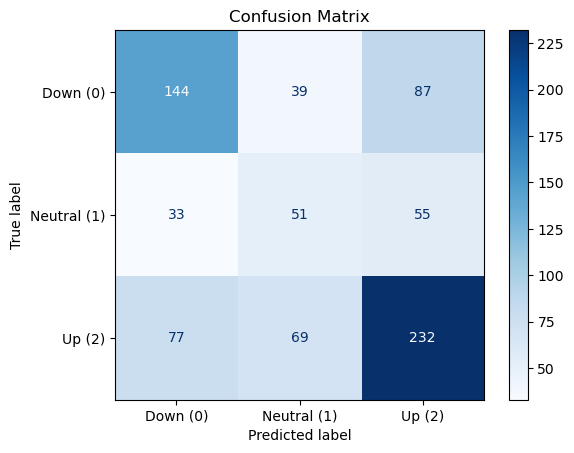

In [6]:
predictions = backtest._strategy.predictions
actuals = backtest._strategy.actuals
evaluate_strategy(predictions, actuals)